# Diffusion mapping tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.diffusion import ADC, DTI
from MDR import MDR, Tools
import ukat.moco.mdr_functions as mdr_functions

# Ensure figures are rendered in the notebook
%matplotlib inline

# Initialise output path for the Model-Driven Registration process
directory = 'diffusion_motion_correction_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

In [3]:
# Fetch test data
pixel_array, affine, bvals, bvecs = fetch.dwi_philips()

In [4]:
# Pre-processing as preparation for the Model-Driven Registration process
pixel_spacing = (np.linalg.norm(affine[:3, 1]), np.linalg.norm(affine[:3, 0]))
elastix_model_parameters = Tools.read_elastix_model_parameters("../ukat/moco/BSplines_DWI.txt")
list_input_parameters = [affine, bvals, None, False]
print(elastix_model_parameters)

ParameterObject (000001D115B66CD0)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 64
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (ASGDParameterEstimationMethod "Original")
  (AutomaticParameterEstimation "true")
  (BSplineInterpolationOrder 1)
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (ErodeFixedMask "false")
  (ErodeMask "false")
  (FinalBSplineInterpolationOrder 1)
  (FinalGridSpacingInPhysicalUnits 50 50)
  (FixedImageDimension 2)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (ImagePyramidSchedule 8 8 4 4 2 2 1 1)
  (ImageSampler "RandomCoordinate")
  (Interpolator "BSplineInterpolator")
  (MaximumNumberOfIterations 500)
  (MaximumStepLength 0.1)
  (Metric "AdvancedMeanSquares")
  (MovingImageDimension 2)
  (MovingImagePyramid "MovingSmoothingImagePyramid")
  (MovingInternalImagePixelType "float")
  (NewSamplesEveryIt

In [5]:
# Model-driven registration
moco_array = []
fit_array = []
for index in range(np.shape(pixel_array)[2]):
    pixel_array_2D = pixel_array[: , :, index, :]
    mdr_output_2D = MDR.model_driven_registration(pixel_array_2D, pixel_spacing, mdr_functions, list_input_parameters, elastix_model_parameters, precision=3, function='DWI_Moco', log=False)
    moco_array_2D = mdr_output_2D[0]
    fit_array_2D = mdr_output_2D[1]
    moco_array.append(moco_array_2D)
    fit_array.append(fit_array_2D)
moco_array = np.stack(moco_array, axis=2)
fit_array_2D = np.stack(fit_array_2D, axis=2)

Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress:   0%|          | 0/79 [00:00<?, ?it/s]

(16384, 79)


Co-registration progress: 100%|██████████| 79/79 [03:05<00:00,  2.34s/it]


In [6]:
# Save motion corrected diffusion sequence to NIfTI
moco_nifti = nib.Nifti1Image(moco_array, affine=affine)
nib.save(moco_nifti, os.path.join(OUTPUT_DIR ,'DWI_motion_corrected.nii.gz'))

In [7]:
# Generate a mask based on the intensity of the b0 volume. This will reduce computation times.
mask = pixel_array[..., 0] > 20000

# Calculate maps from the original diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(pixel_array, affine, bvals, mask=mask, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps='all')

# Calculate maps from the original diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(pixel_array, affine, bvals, bvecs, mask=mask, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps=['md', 'fa'])

# Calculate maps from the motion corrected diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(moco_array, affine, bvals, mask=mask, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps='all')

# Calculate maps from the motion corrected diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(moco_array, affine, bvals, bvecs, mask=mask, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps=['md', 'fa'])

100%|██████████| 57096/57096 [00:07<00:00, 7832.98it/s]


(-0.5, 127.5, 127.5, -0.5)

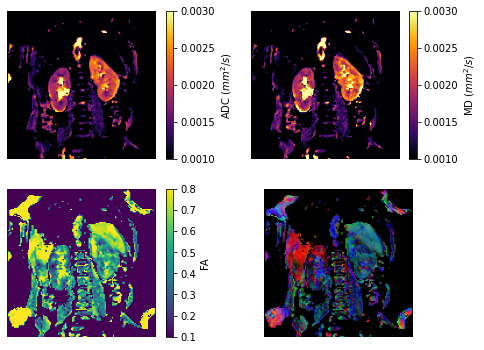

In [8]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper.adc[:, :, adc_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper.md[:, :, dti_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper.fa[:, :, dti_mapper.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper.color_fa[:, :, dti_mapper.shape[2]//2, :]))
ax[1, 1].axis('off')